In [1]:
import numpy as np
from pydpmd.data import RigidBumpy, load
from pydpmd.plot import draw_particles_frame, create_animation, downsample
from correlation_functions import compute_msd, compute_shear_modulus, compute_rotational_msd, compute_pair_correlation_function, compute_vacf, compute_rotational_msd
from pydpmd.calc import run_binned, fused_msd_kernel, TimeBins, LagBinsExact, LagBinsLog, LagBinsLinear, LagBinsPseudoLog, requires_fields
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
import re
from tqdm import tqdm

def get_relaxation_time(f, t):
    tau = np.interp(1 / np.e, f[::-1], t[::-1])
    if not np.min(f) < 1 / np.e:
        return np.nan
    return tau

In [53]:
root = "/home/mmccraw/dev/data/09-31-25/testing-code/"
nv_hist = []
mu_hist = []
temp_hist = []
phi_hist = []
te_fluc_hist = []
p_hist = []
msd_hist = []
shear_modulus_hist = []
t_hist = []
for run_name in os.listdir(root):
    if 'dynamics_' not in run_name:
        continue
    run_dir = os.path.join(root, run_name)
    try:
        data = load(run_dir, location=['final', 'init'], load_trajectory=True, load_full=True)
    except:
        continue
    data.calculate_mu_eff()
    nv = data.n_vertices_per_particle[data.system_offset[:-1]]
    mu = data.mu_eff[data.system_offset[:-1]]
    temp = np.mean(data.trajectory.temperature, axis=0)
    phi = data.packing_fraction.copy()
    p = np.mean(data.trajectory.pressure, axis=0)
    te = data.trajectory.pe_total + data.trajectory.ke_total
    te_fluc = np.std(te, axis=0) / np.mean(te, axis=0)

    if not 'stress_tensor_total_x' in data.trajectory.fields():
        continue

    shear_modulus_path = os.path.join(run_dir, "shear_modulus.npz")
    shear_modulus, t = compute_shear_modulus(data, shear_modulus_path)

    msd_path = os.path.join(run_dir, "msd.npz")
    msd, t = compute_msd(data, msd_path)

    nv_hist.append(nv)
    mu_hist.append(mu)
    temp_hist.append(temp)
    phi_hist.append(phi)
    p_hist.append(p)
    te_fluc_hist.append(te_fluc)
    shear_modulus_hist.append(shear_modulus)
    msd_hist.append(msd)
    t_hist.append(t)

mu_flat = np.concatenate(mu_hist)
nv_flat = np.concatenate(nv_hist)
phi_flat = np.concatenate(phi_hist)
mu_norm = LogNorm(vmin=mu_flat.min(), vmax=mu_flat.max())
phi_norm = LogNorm(vmin=phi_flat.min(), vmax=phi_flat.max())
cmap = plt.cm.viridis

7.0
7.0
7.0
7.0
7.0


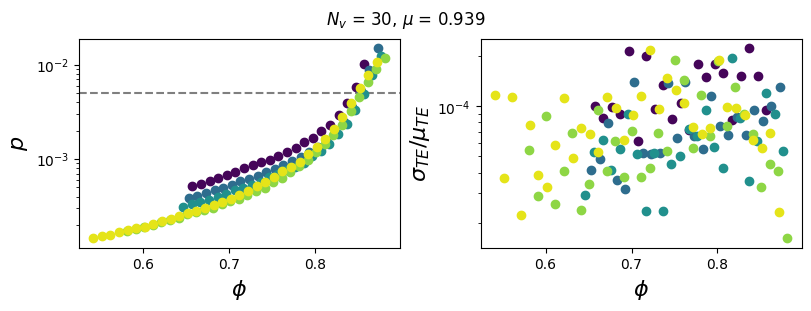

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True)
for mu, nv in np.unique(np.column_stack((mu_flat, nv_flat)), axis=0):
    if nv != 7:
        continue
    print(nv)
    for nv_list, mu_list, temp_list, phi_list, p_list, te_fluc_list in zip(nv_hist, mu_hist, temp_hist, phi_hist, p_hist, te_fluc_hist):
        if nv not in nv_list and mu not in mu_list:
            continue
        if not np.any((nv_list == nv) & (mu_list == mu)):
            continue
        i = np.argwhere((nv_list == nv) & (mu_list == mu))[0]
        temp = temp_list[i]
        phi = phi_list[i]
        p = p_list[i]
        te_fluc = te_fluc_list[i]
        ax[0].scatter(phi, p, color=cmap(mu_norm(mu)))
        ax[1].scatter(phi, te_fluc, color=cmap(mu_norm(mu)))
ax[0].set_yscale('log')
ax[0].axhline(5e-3, c='k', ls='--', zorder=0, alpha=0.5)
ax[1].set_yscale('log')
ax[0].set_xlabel(r'$\phi$', fontsize=16)
ax[0].set_ylabel(r'$p$', fontsize=16)
ax[1].set_xlabel(r'$\phi$', fontsize=16)
ax[1].set_ylabel(r'$\sigma_{TE} / \mu_{TE}$', fontsize=16)
plt.suptitle(fr'$N_v$ = {int(nv) - 1}, $\mu$ = {mu:.3f}')
plt.show()

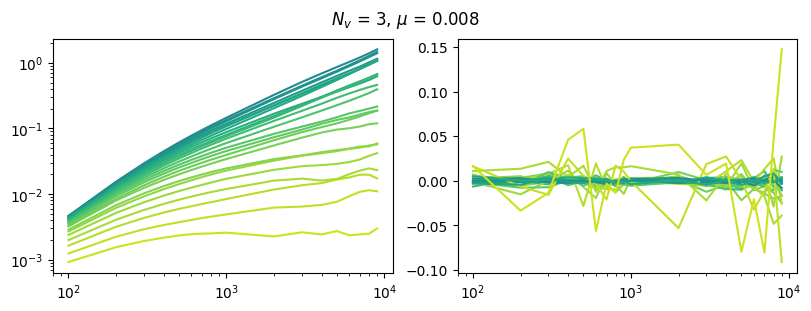

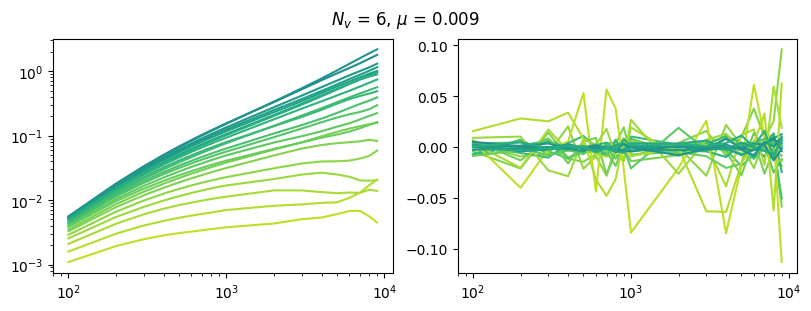

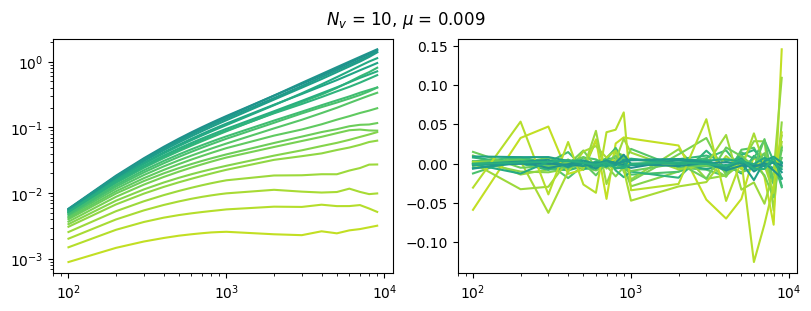

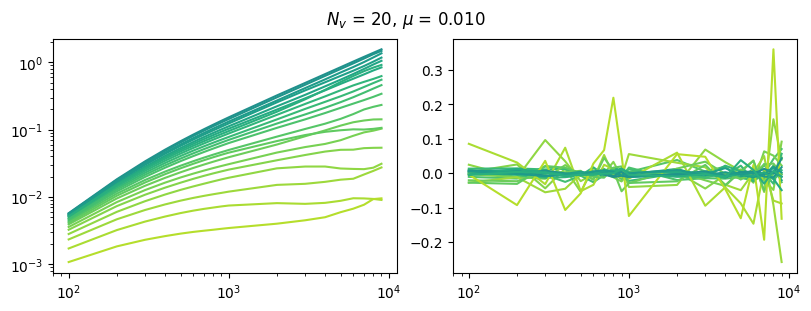

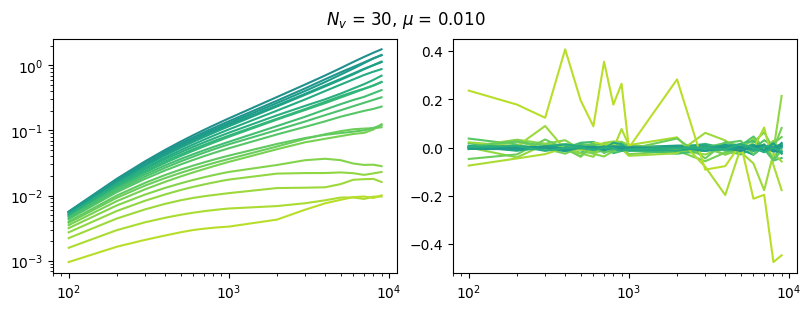

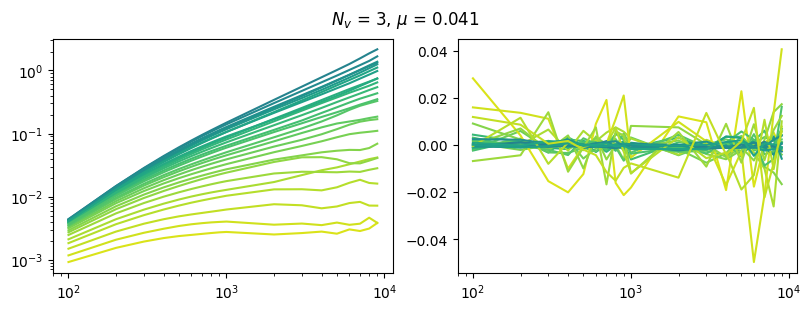

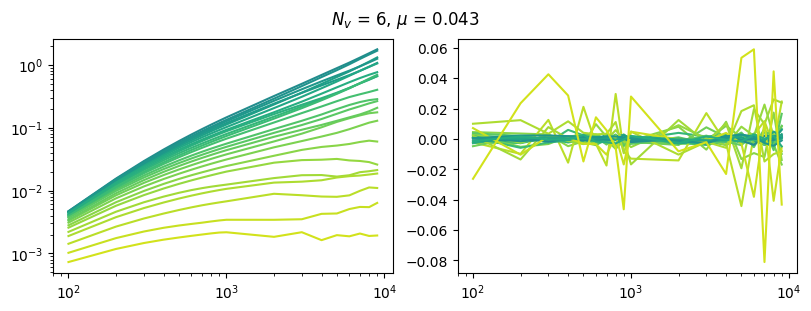

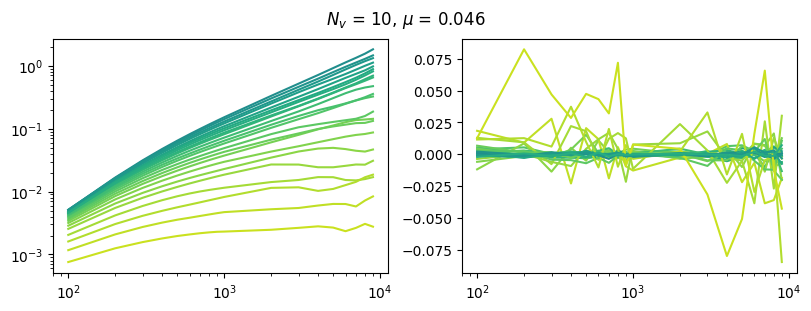

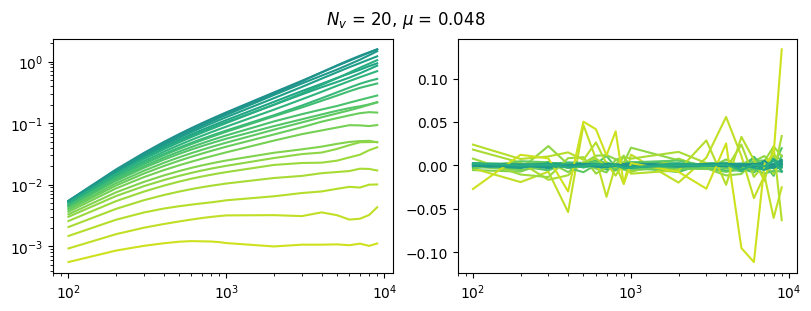

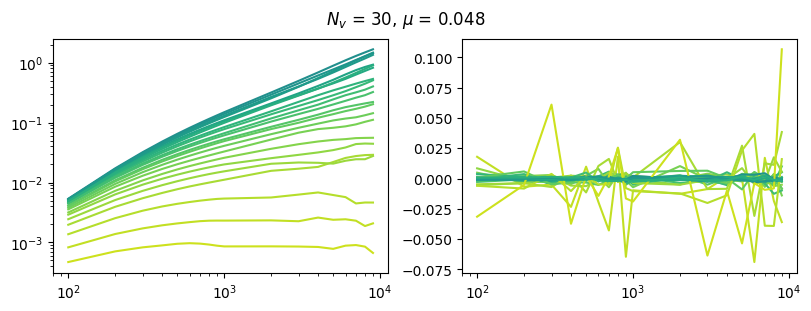

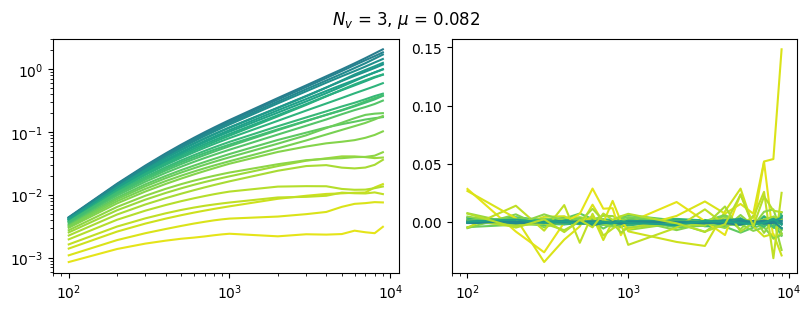

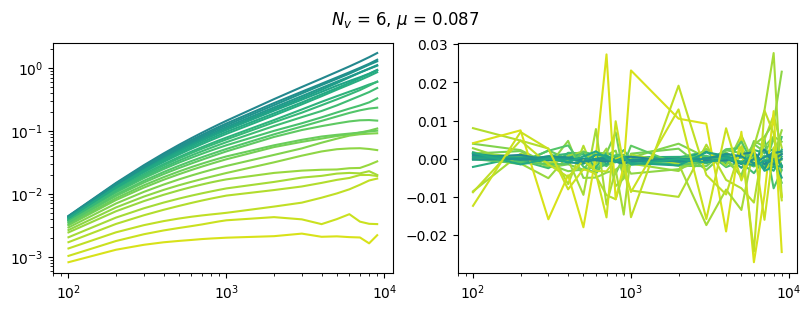

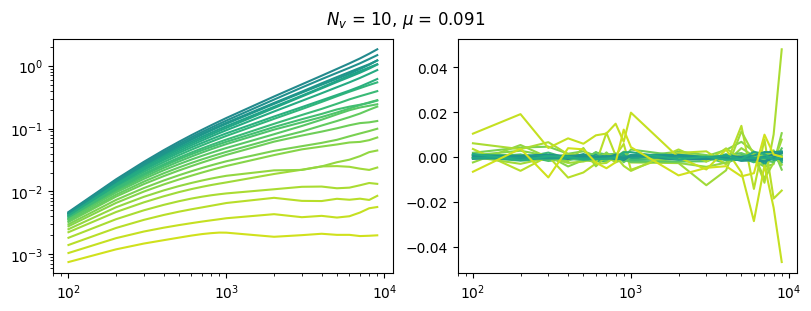

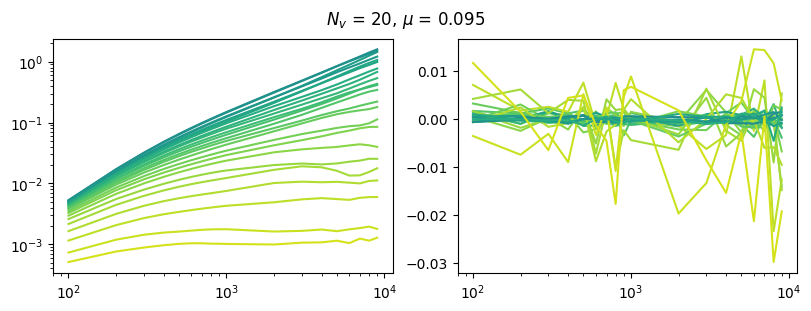

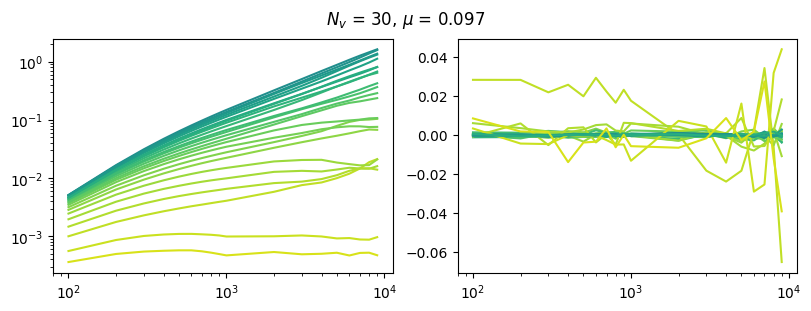

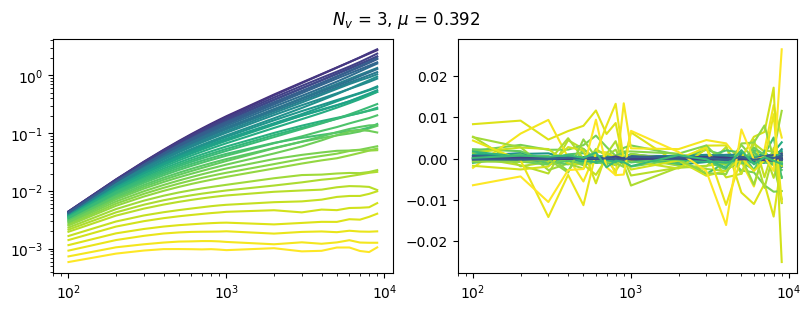

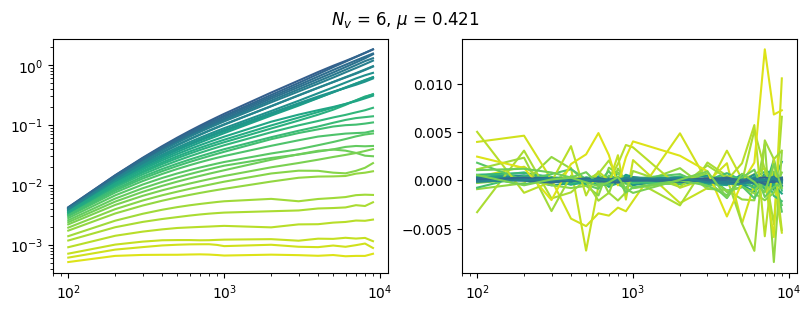

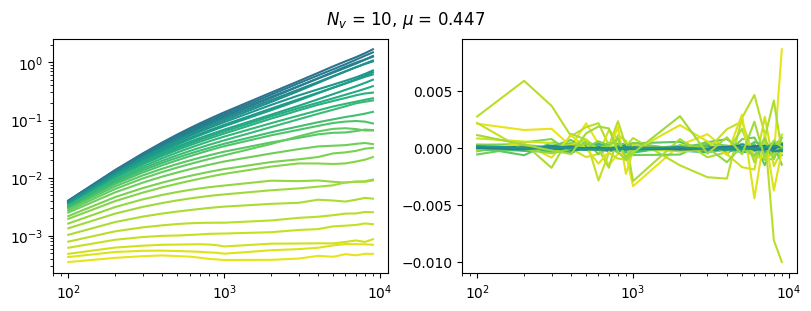

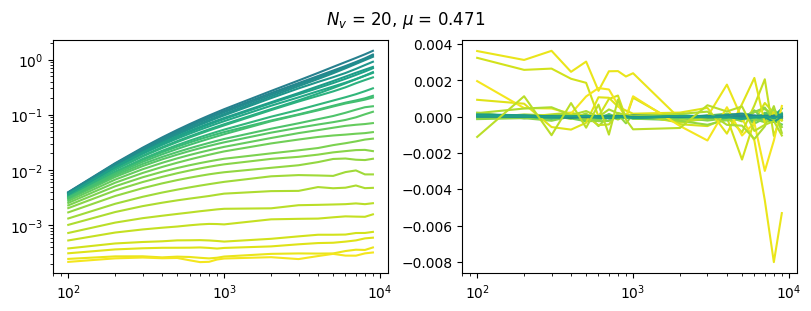

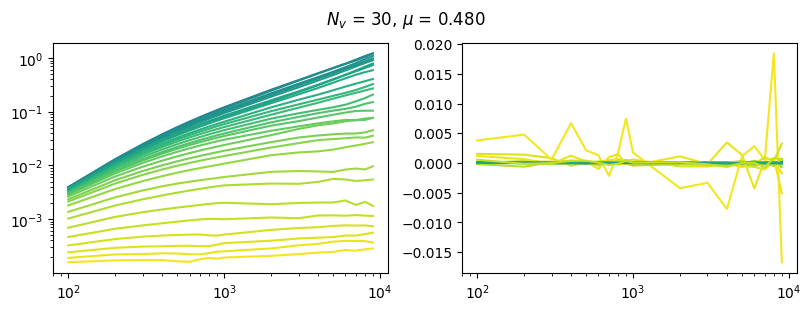

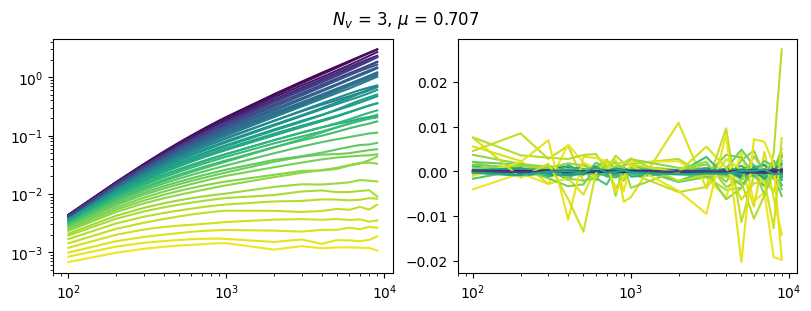

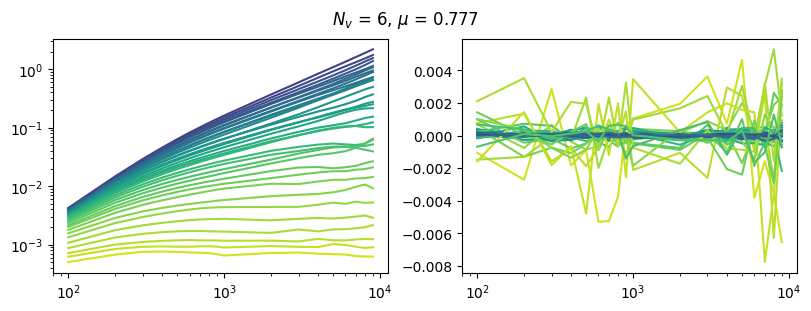

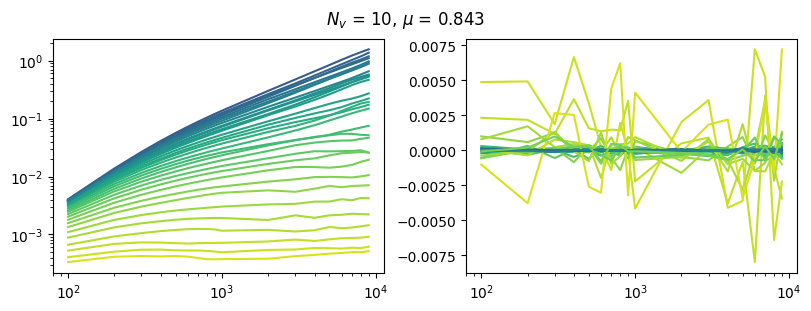

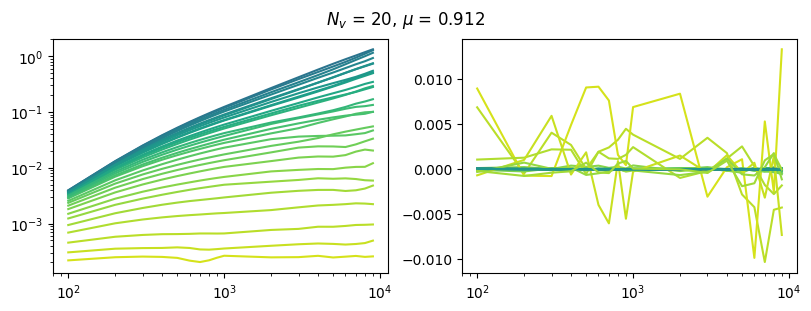

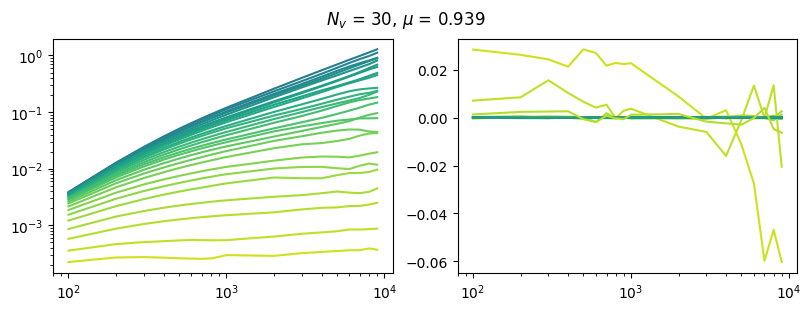

In [55]:
for mu, nv in np.unique(np.column_stack((mu_flat, nv_flat)), axis=0):
    fig, ax = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True)
    for nv_list, mu_list, temp_list, phi_list, msd_list, shear_modulus_list, t in zip(nv_hist, mu_hist, temp_hist, phi_hist, msd_hist, shear_modulus_hist, t_hist):
        if nv not in nv_list and mu not in mu_list:
            continue
        if not np.any((nv_list == nv) & (mu_list == mu)):
            continue
        i = np.argwhere((nv_list == nv) & (mu_list == mu))[0]
        temp = temp_list[i]
        phi = phi_list[i]
        msd = msd_list[:, i].squeeze()
        shear_modulus = shear_modulus_list[:, i].squeeze()
        ax[0].plot(t, msd, color=cmap(phi_norm(phi)))
        ax[1].plot(t, shear_modulus, color=cmap(phi_norm(phi)))
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[1].set_xscale('log')
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}, $\mu$ = {mu:.3f}')
    plt.show()


In [61]:
data = load('/home/mmccraw/dev/data/09-31-25/testing-code-final/dynamics_0', location=['final', 'init'], load_trajectory=True, load_full=True)
msd_path = os.path.join(run_dir, "msd.npz")
msd, t = compute_msd(data, msd_path)

shear_modulus_path = os.path.join(run_dir, "shear_modulus.npz")
shear_modulus, t = compute_shear_modulus(data, shear_modulus_path)

Loading trajectory:   0%|          | 0/9 [00:00<?, ?it/s]

Binned accumulation: 100%|██████████| 310005/310005 [00:01<00:00, 199696.06it/s]


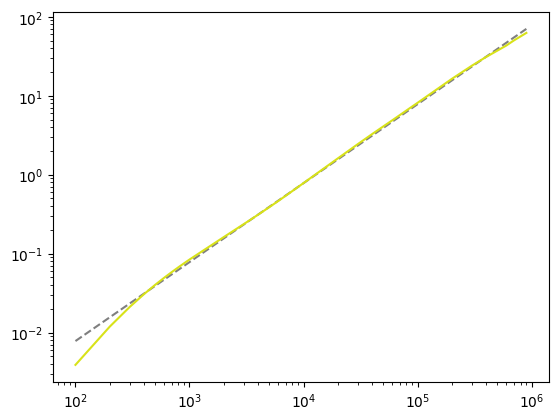

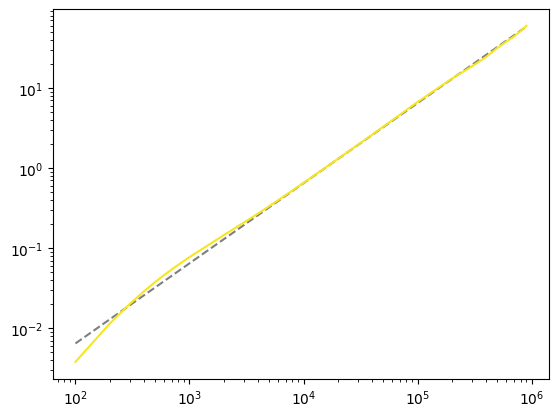

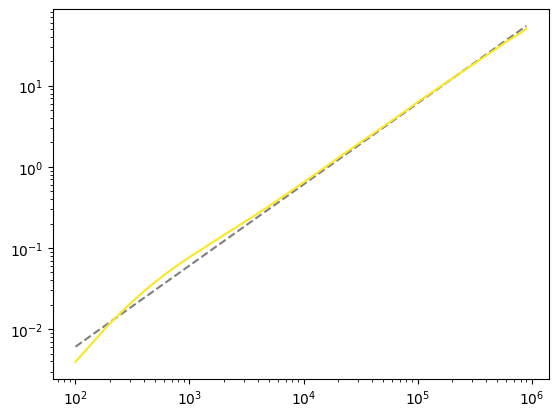

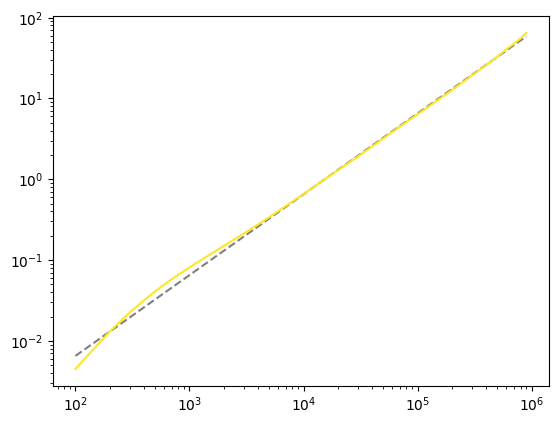

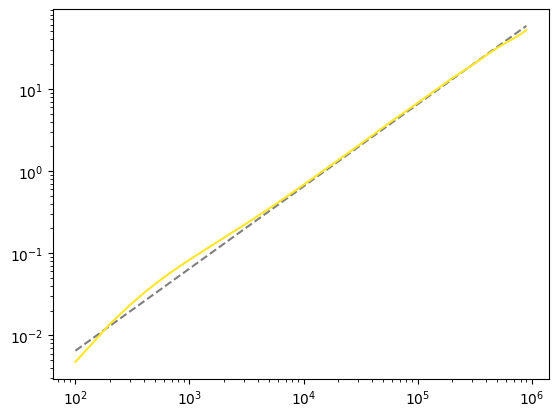

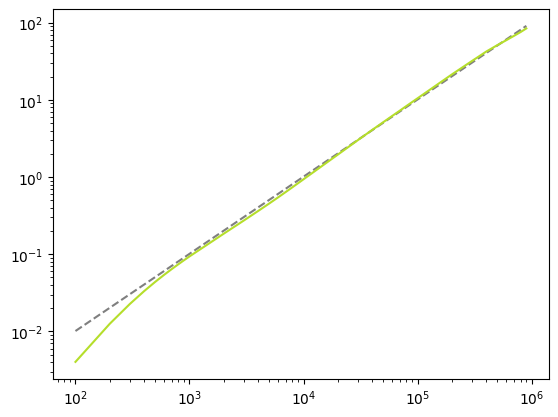

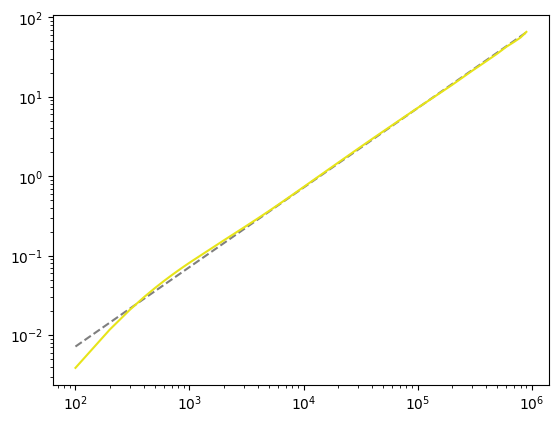

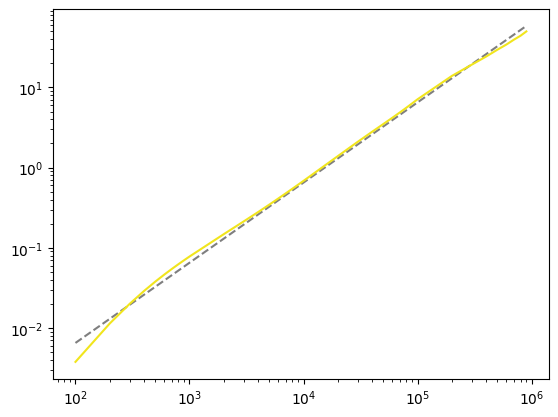

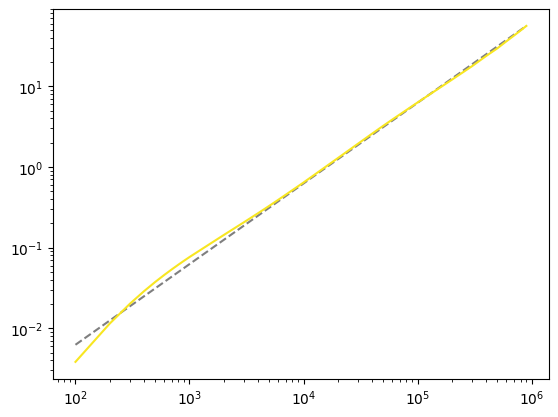

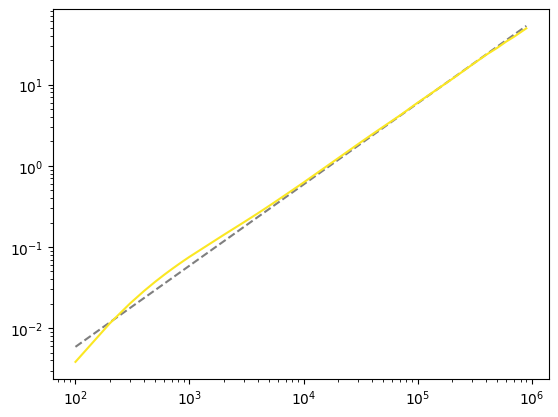

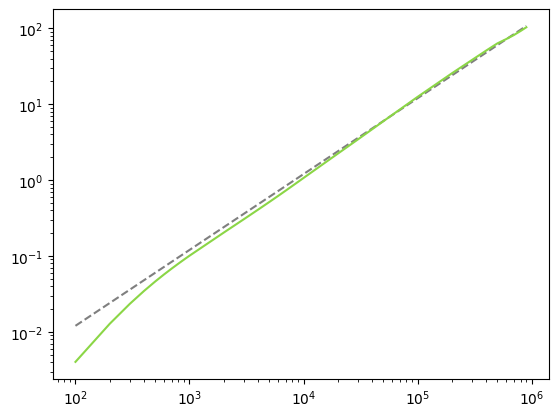

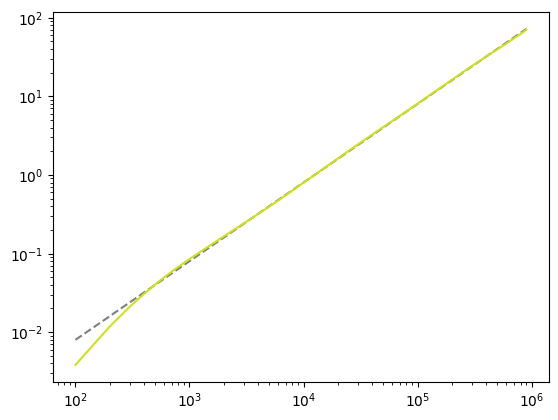

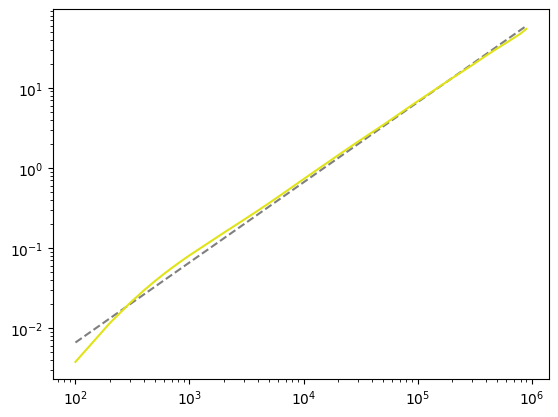

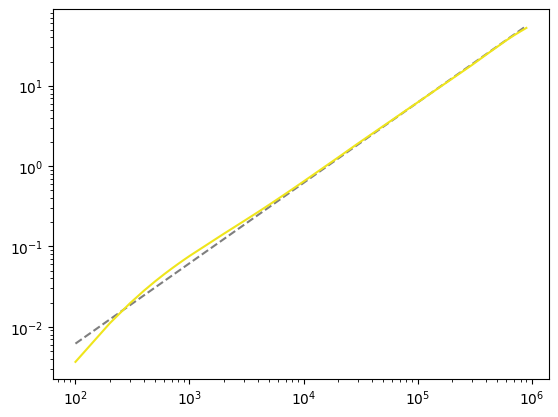

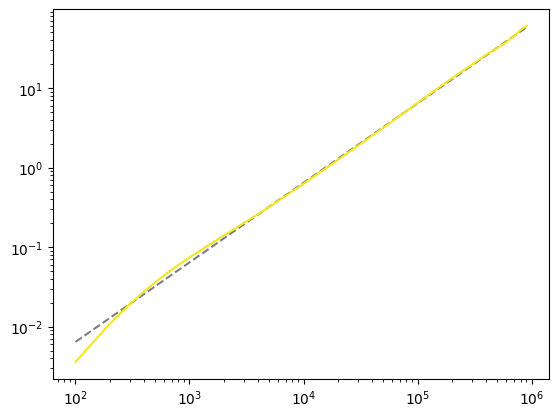

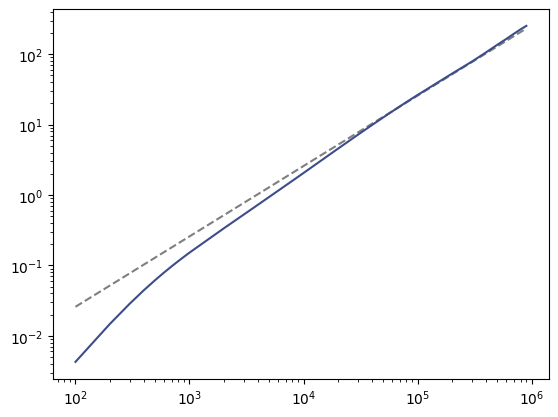

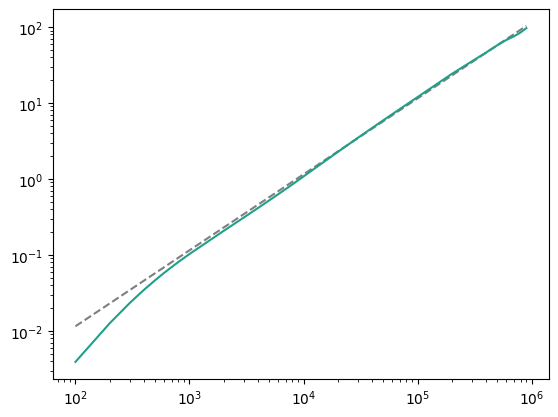

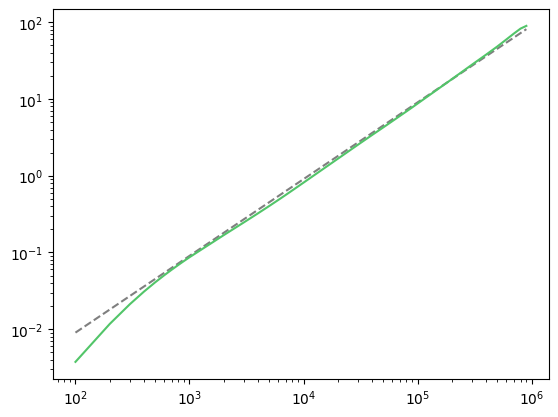

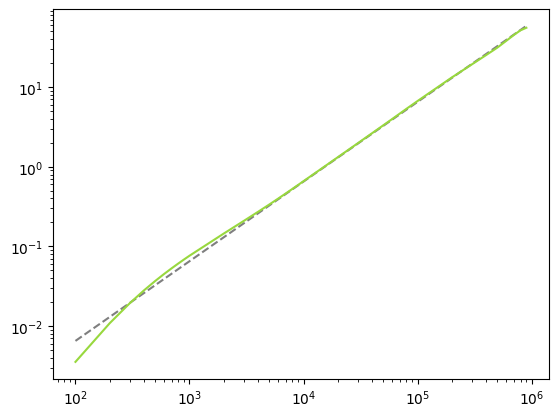

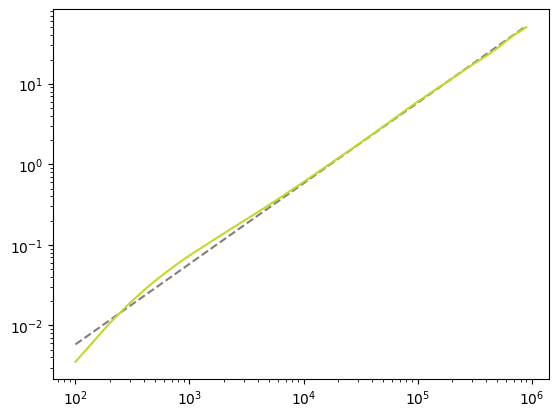

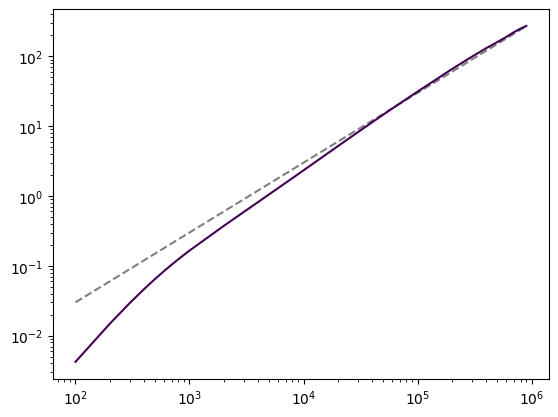

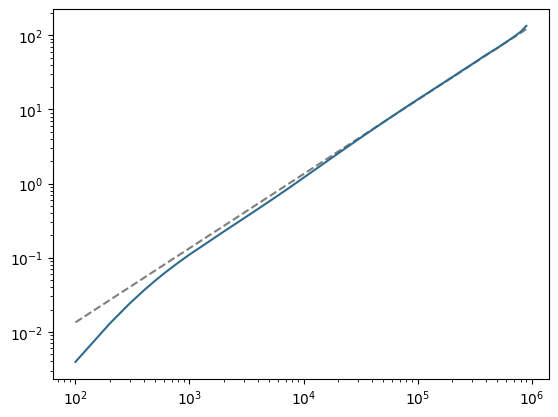

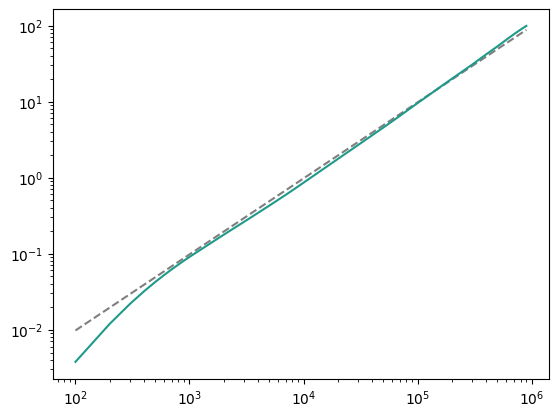

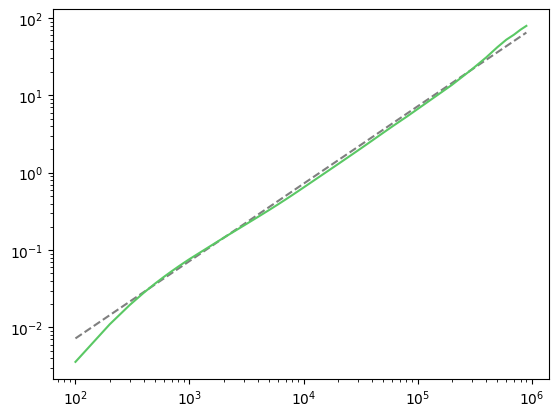

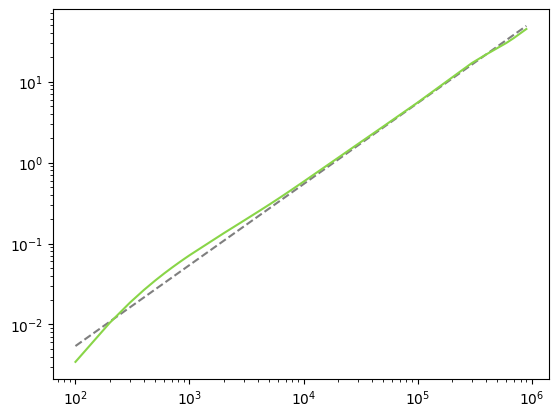

In [71]:
from scipy.optimize import minimize
def obj_func(b, x, y):
    return np.sum((x + b - y) ** 2)

phi_norm = plt.Normalize(vmin=data.packing_fraction.min(), vmax=data.packing_fraction.max())
cmap = plt.cm.viridis

for i in range(msd.shape[1]):
    plt.plot(t, msd[:, i], c=cmap(phi_norm(data.packing_fraction[i])))

    fit_mask = t > t.max() / 1e2
    D = 10 ** minimize(obj_func, x0=1, args=(np.log10(t[fit_mask]), np.log10(msd[:, i][fit_mask]))).x[0]
    plt.plot(t, t * D, c='k', ls='--', alpha=0.5, zorder=0)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

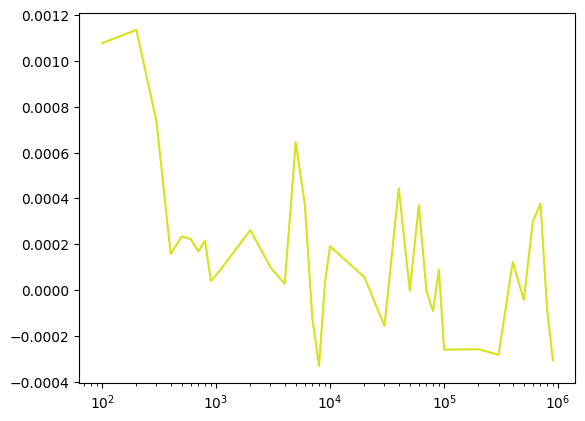

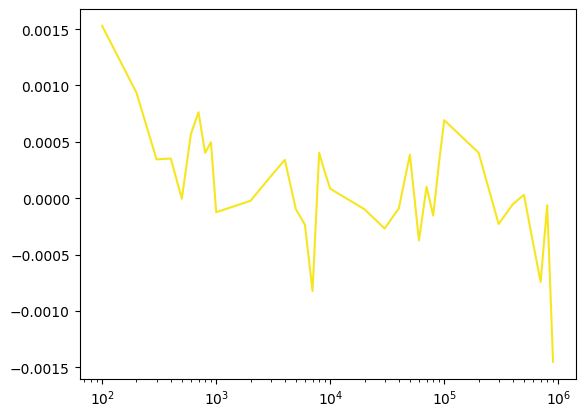

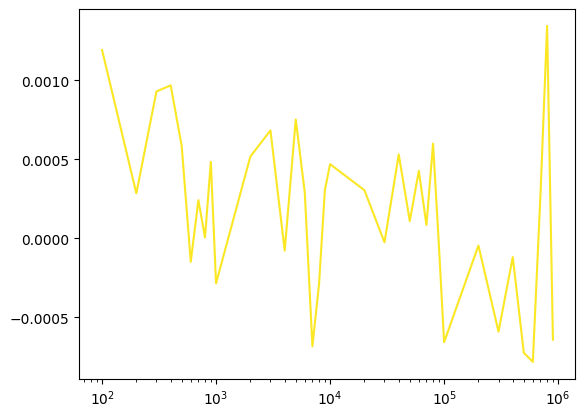

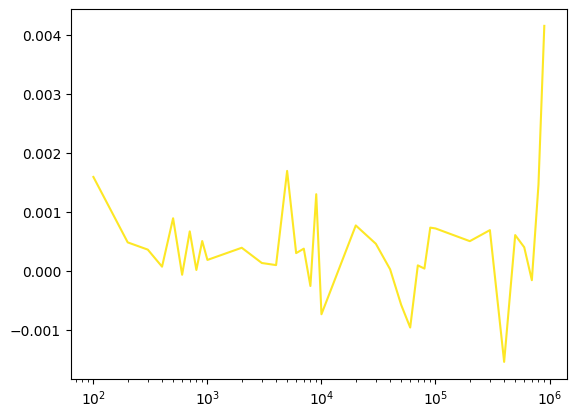

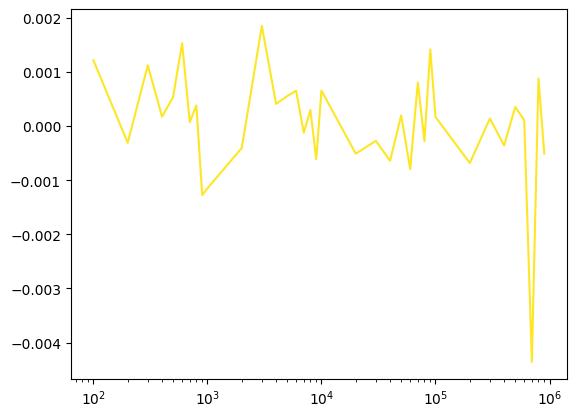

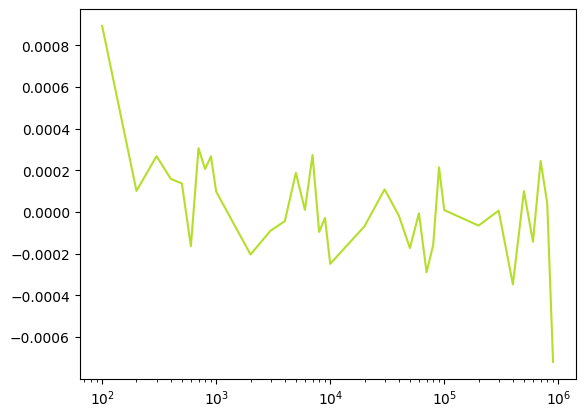

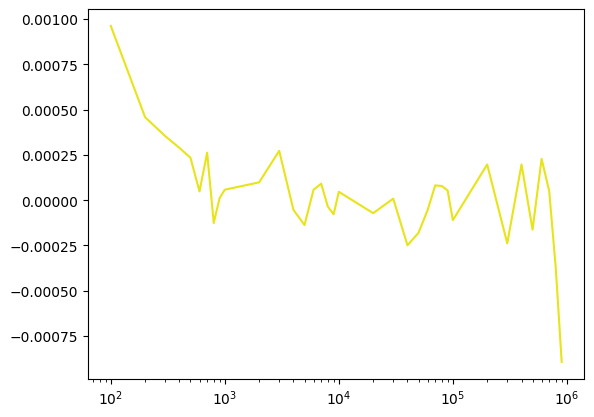

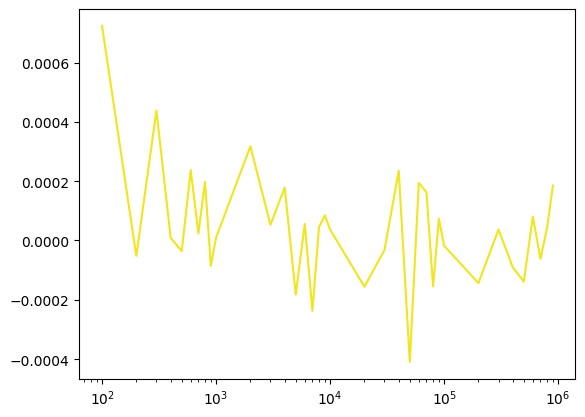

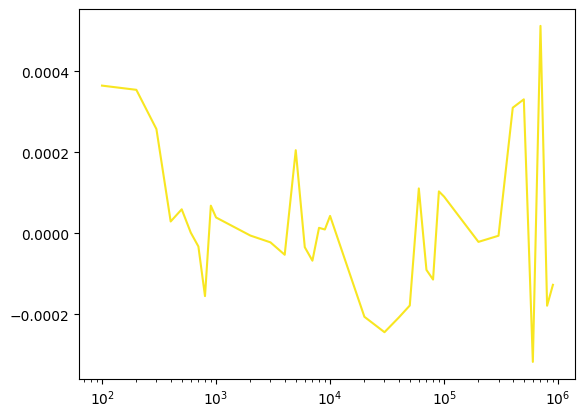

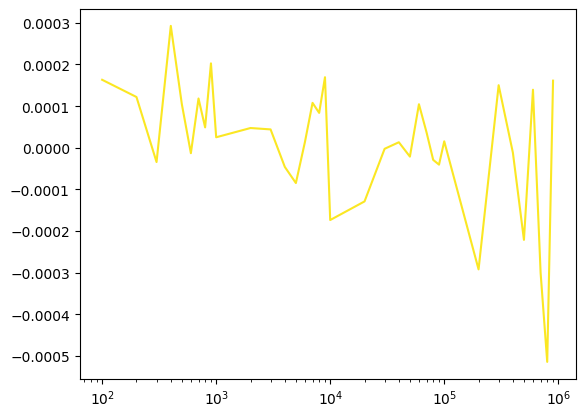

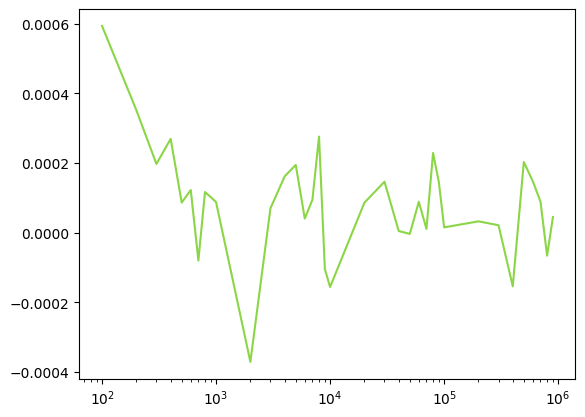

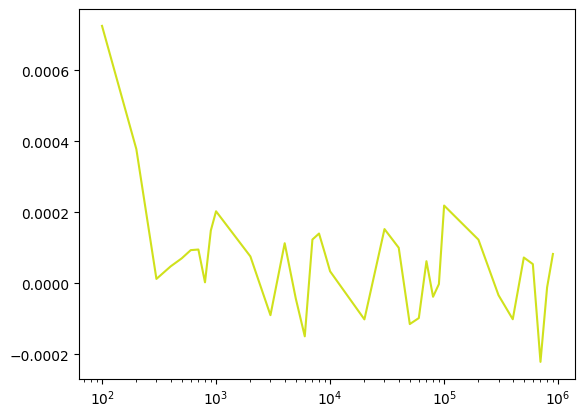

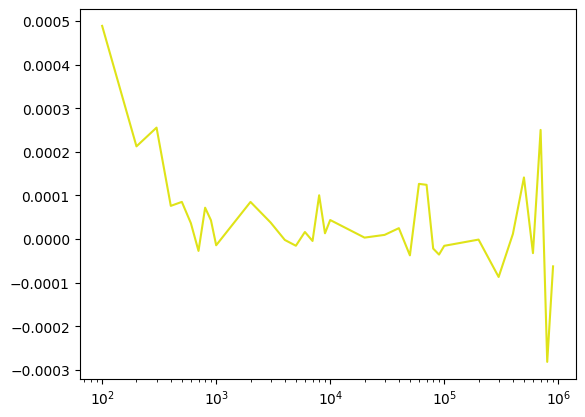

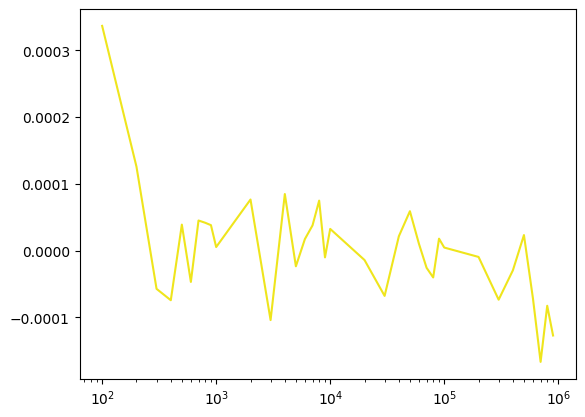

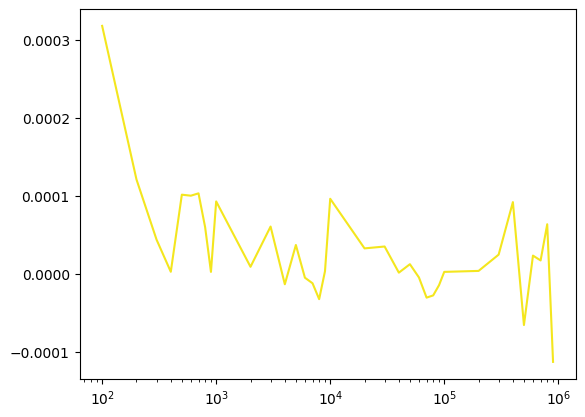

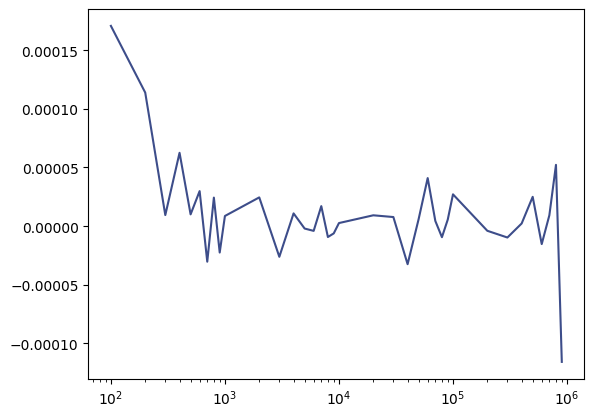

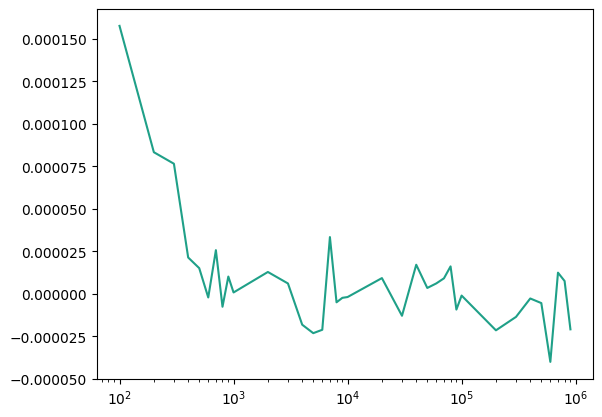

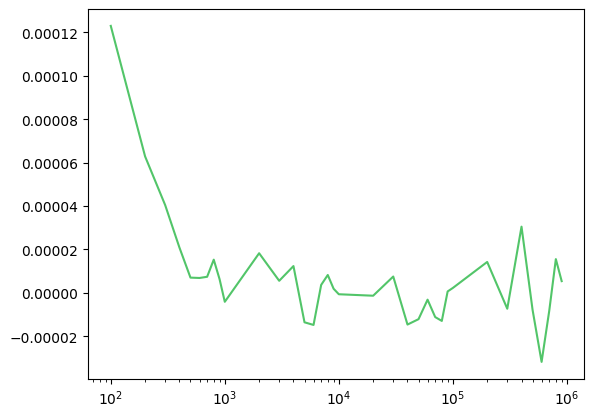

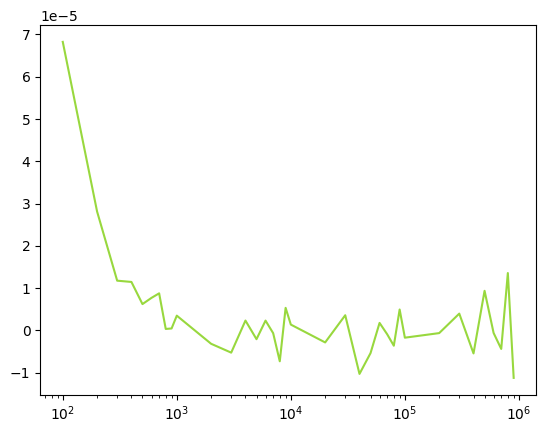

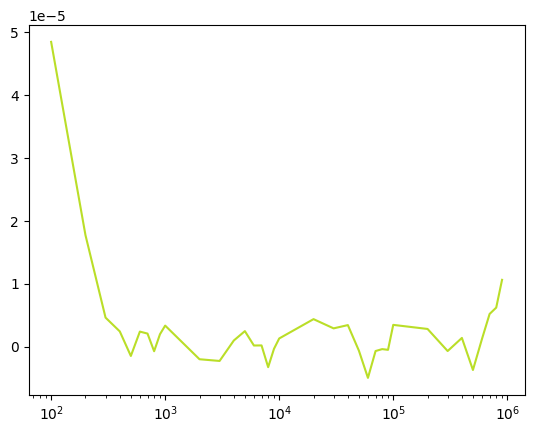

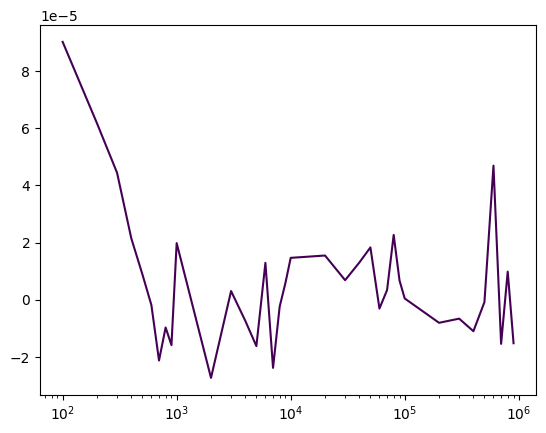

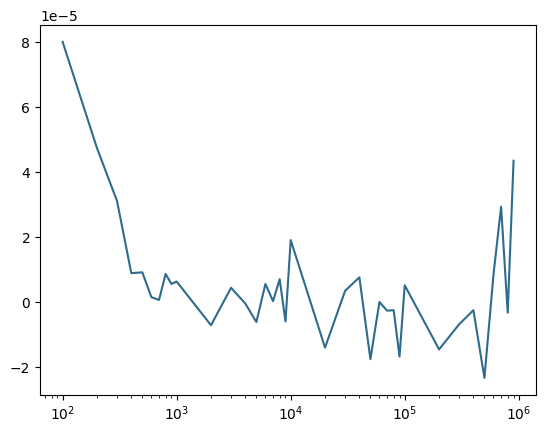

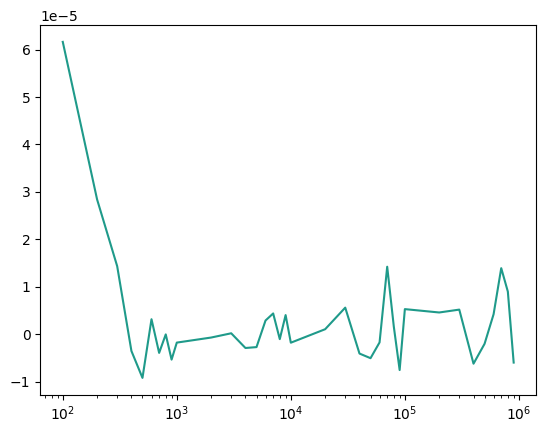

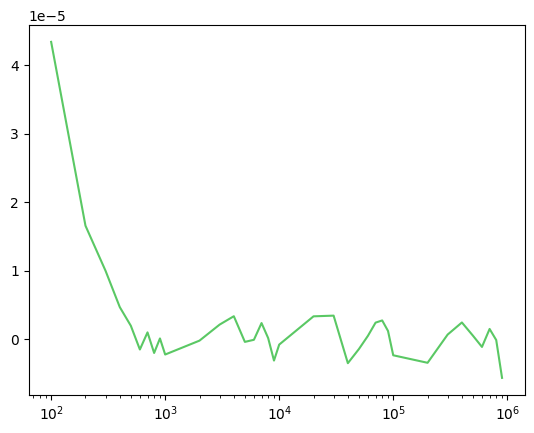

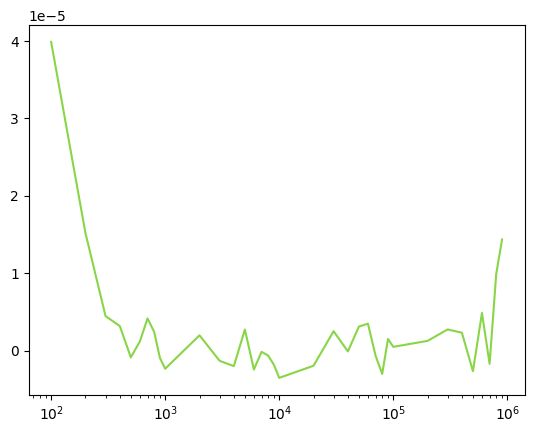

In [72]:
for i in range(msd.shape[1]):
    plt.plot(t, shear_modulus[:, i], c=cmap(phi_norm(data.packing_fraction[i])))
    plt.xscale('log')
    plt.show()